In [3]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import permutations

In [15]:
# algorithm

def GraphAnon(edgeList,K):

    'executes graph anaonymization algorithm 1.'
    
    t1=pd.Timestamp.now()
    
    logFile=open("Edges.txt","w")

    # graph creation

    graph=nx.Graph()

    graph.add_edges_from(edgeList)

    edgesOriginal=len(graph.edges())

    nodesOriginal=len(graph.nodes())
    

    # 1. cut vertices

    cutVertices=list(nx.articulation_points(graph))
    
#     cutVertices=len(cutVertices)

    # 2. bridges


    bridges=list(nx.bridges(graph))
    
#     bridges=len(bridges)

    # 3. average degree

    avgDegree=len(graph.edges())/len(graph.nodes())
#     avgDegree = 2
    

    degrees={}

    # frequency calculations
    nodes=list(graph.nodes)
    freq=[]
    for n in nodes:
        adjLength=len(list(graph.adj[n]))
        if str(adjLength) not in degrees.keys():
           degrees[str(adjLength)]=1
        elif adjLength in degrees.keys():
            degrees[str(adjLength)]+=1
        freqWeight=adjLength/len(nodes)
        freq.append(freqWeight)
    
    # maximum frequency

    freqMax=max(freq)


    if round(avgDegree)!=avgDegree:
        avgDegree=round(avgDegree+1)
    
    print("Executing Graph anonymization algorithm.")
    print("Average degree:",avgDegree)
    print("Bridges:",len(bridges))
    print("Cut Vertices:",len(cutVertices))
    print("Frequency:",freqMax)
    
    
     # edges by strength

    strongEdges,weakEdges=EdgesByStrength(graph=graph,freqMax=freqMax)

    print("Strong Edges:",len(strongEdges))
    
    print("Weak Edges:",len(weakEdges))
    
       
    # Finding degree sequence of cutVertices
    
    
#         degree_sequence = [d for n, d in graph.degree()]  # degree sequence
#         print(f"Degree sequence {degree_sequence}")
#         print("degree list: ",sorted(degree_sequence))
#         print(f"Degree sequence {cutVertices}")  


    # 4. Edges and nodes on bridges

    graph=Step4(graph=graph,bridges=bridges)  


    # New cut vertices and bridges

    cutVertices=list(nx.articulation_points(graph))

    bridges=list(nx.bridges(graph))

    print("New Cut Vertices:",cutVertices)

    print("New Bridges:",bridges)
    
    # 5. Edges among cut vertices

    if len(cutVertices)!=0 :

        noMaxEdges=int((len(cutVertices)*(len(cutVertices)-1))/2)

        print('Executing step 4.')

        edgesAdded=0
        for i in range(len(cutVertices)):
            for j in cutVertices[i+1:]:
                if (cutVertices[i],j) not in list(graph.edges()) and edgesAdded<noMaxEdges:
                    graph.add_edge(cutVertices[i],j,createdAt='step4')
                    edgesAdded+=1
        
        print("Edges added at 4th step:",edgesAdded)
        
  
    
    # # Deprecated. New nodes for each bridge
    
    # if len(bridges)!=0:
        
    #     edgesAdded5=0

    #     dbNodes=[]
    #     print('Executing step 5.')
    #     i=1
    #     for k,v in bridges:
    #         e1=[('d'+str(i),k),('d'+str(i),v)]
    #         dbNodes.append('d'+str(i))
    #         for e in e1:
    #             if e not in list(graph.edges()):
    #                 #stp2Edges.append(e)
    #                 graph.add_edge(e[0],e[1],createdAt='step5')
                    
    #                 edgesAdded5+=1
    #         i+=1
        
    #     print("Edges added at 5th step:",edgesAdded5)
    
    # 6. Step6

    cutVertices=list(nx.articulation_points(graph))

    bridges=list(nx.bridges(graph))

    if len(bridges)!=0:
        
        edgesAdded6=0

        print('Executing step 6.')

        for a,b in bridges:

            edgeToAdd=Step6(a=a,b=b,graph=graph,avgDegree=avgDegree,threshold=freqMax)     
            

            if len(edgeToAdd)!=0 and edgeToAdd not in list(graph.edges()):
                graph.add_edge(edgeToAdd[0],edgeToAdd[1],createdaAt='step6')
                
                edgesAdded6+=1
        
        print("Edges added at 6th step:",edgesAdded6)


    
    
#     7.Duplicate nodes for cut vertices.

    cutVertices=list(nx.articulation_points(graph))

    bridges=list(nx.bridges(graph))

    if len(cutVertices)!=0:
        print('Executing step 7.')   

        step7Edges=[]
        d1Nodes=[]
        for v in cutVertices:
            step7Edges.append(("V->"+str(v),v))
            d1Nodes.append("V->"+str(v))

        if len(cutVertices)>1:
            step7_1Edges=[]
            for i in range(len(step7Edges)):
                if i==len(step7Edges)-1:
                    step7_1Edges.append((step7Edges[i][0],step7Edges[0][0]))
                else:
                    step7_1Edges.append((step7Edges[i][0],step7Edges[i+1][0]))
            step7Edges+=step7_1Edges
                   
        for a,b in step7Edges:
            graph.add_edge(a,b,createdAt="step7")
        
        print("Edges added at 7th step:",len(step7Edges))


    # additional step

    cVert=list(nx.articulation_points(graph))
    
    if len(cVert)==1:

        noEdgesAddMax=1

        edgesAddedAddnl=0

        for c in cVert:

            cAdjNodes=list(graph.adj[c])

            edgeFlag=0

            for cAdjNode in cAdjNodes:

                edgeAddC=Step6(a=c,b=cAdjNode,avgDegree=avgDegree,threshold=freqMax,graph=graph)

                if len(edgeAddC)!=0 and edgeFlag<noEdgesAddMax:

                    graph.add_edge(edgeAddC[0],edgeAddC[1],createdAt='SilenceCVert')
                    graph.add_edge(edgeAddC[0],"V->"+str(c),createdAt="SilenceCVert")
                    graph.add_edge(edgeAddC[1],'V->'+str(c),createdAt='SilenceCVert')

                    edgeFlag+=1

                    edgesAddedAddnl+=3
                    
        cVert2=list(nx.articulation_points(graph))
        d1Nodes=[]
        for cv in cVert2:
            dupNode="V->"+str(cv)
            for d1 in d1Nodes:
                graph.add_edge(cv,d1,createdAt="SilenceCVert")
                graph.add_edge(dupNode,d1,createdAt="SilenceCVert")
                
                edgesAddedAddnl+=1
                
        print("Edges added at Addnl step:",edgesAddedAddnl)  
    
    edgesAddedTillStep7=len(graph.edges())
    
    
    
    print("Total edges added After step7:",edgesAddedTillStep7-edgesOriginal)
    
    
            
     # Step 8 (2021-09-07)

    print('Executing step 8.') 
    
    u=[x for x in list(graph.nodes) if len(graph.adj[x])<K]

    print("U:",u)

    ls=[1,2,3]

    for l in ls:

        graph=PrivacyPara(l=l,u=u,k=K,graph=graph)
        
        nx.write_gexf(graph, "K%d_L%d.gexf"%(K,l))

        logFile.write("K:%d;L:%d;\nEdges:%s"%(K,l,str(graph.edges())))

        logFile.write("\n")

        #print("Edges:",graph.edges())  
            
    
    # 9. add edges among non adjacent nodes

    cutVertices=list(nx.articulation_points(graph))

    edgesStep8=0

    bridges=list(nx.bridges(graph))

    if len(cutVertices)==0 and len(bridges)==0:

        print('Executing step 8.') 
        
        nodesGDegree=[x for x in list(graph.nodes) if len(graph.adj[x])>=avgDegree]

        step8EdgesPrep=[]

        edgeCount=0
        for i in range(len(nodesGDegree)):
            if edgeCount>=avgDegree:
                break
            for node in nodesGDegree[i+1:]:
                if (nodesGDegree[i],node) not in graph.edges() and edgeCount<avgDegree:
                    step8EdgesPrep.append((nodesGDegree[i],node))
                    edgeCount+=1
                elif edgeCount>=avgDegree:
                    break
        
        step8Edges=[]
        dupNodes=[]
        for a,b in step8EdgesPrep:
            if str(a)+'*' not in dupNodes:
                dupNodes.append(str(a)+"*")
                step8Edges+=[(str(a)+'*',a),(str(a)+'*',b)]
            else:
                dupNodes.append(str(b)+'*')
                step8Edges+=[(str(b)+"*",a),(str(b)+'*',b)]
        
        for a,b in step8Edges:
            graph.add_edge(a,b,createdAt="step8")

            edgesStep8+=1
    
    print("edges added at step8:",edgesStep8)
            
   

    # 2. edges

    colorEdges=[]

    nEdgesAdded=0
    nEdgesAddedCutVert=0

    for a,b,r in graph.edges.data('createdAt'):
        if r==None:
            colorEdges.append('black')
        elif r=="SilenceCVert":
            colorEdges.append('red')
        
        elif r=='step4' :
            colorEdges.append('yellow')
            nEdgesAdded+=1
            nEdgesAddedCutVert+=1
        elif r=="step5":
            colorEdges.append('green')

        else:
            colorEdges.append("blue")
            nEdgesAdded+=1
    
    # 1. nodes

    colorNodes=[]
    for node in graph.nodes():
        if node in cutVertices:
            colorNodes.append("red")
        else:
            colorNodes.append('green')

        

        
    # nx.draw(graph,with_labels=True,node_size=1000,edge_color=colorEdges,node_color=colorNodes)  # networkx draw()
    # print(plt.draw()) 

    noEdgesAdded=len(graph.edges())-edgesOriginal

    nodesAdded=len(graph.nodes())-nodesOriginal

    print("No of Edges Added:",noEdgesAdded)

    print("No of duplicate nodes:",nodesAdded)
    
    logFile.close()
    
    
    
    return list(graph.edges())


def Step6(a,b,graph,threshold,avgDegree):

    'builds relationship based on neighbourhood'

    adjParent=list(graph.adj[a])
    adjNode=list(graph.adj[b])

    cond1NodesA=[x for x in adjParent if len(graph.adj[x])>=avgDegree]
    cond1NodesB=[x for x in adjNode if len(graph.adj[x])>=avgDegree]

    if len(cond1NodesA):
        cond1NodesA=adjParent

    if len(cond1NodesB):
        cond1NodesB=adjNode
    
    edgeAdd=()
    
    for parent in cond1NodesA:

        adjParent1=list(graph.adj[parent])

        for node in cond1NodesB:
            #print("".ljust(25,'*'))
            if node == parent:
                continue
            adjNode1=list(graph.adj[node])
            #commonNeighbours=[x for x in adjParent1 if x in adjNode1]
            commonNeighbours=list(set(adjParent1).intersection(adjNode1))
            try:            
                neighValue=len(commonNeighbours)/((len(adjParent1)-1)+(len(adjNode1)-1)-len(commonNeighbours))
            except ZeroDivisionError:
                continue
            if (parent,node) not in graph.edges() and parent !=node:
                if len(edgeAdd)==0:
                    edgeAdd=(parent,node,neighValue)
                elif len(edgeAdd)!=0 and neighValue<edgeAdd[2]:
                    edgeAdd=(parent,node,neighValue)
    
    return edgeAdd

def PrivacyPara(l,u,k,graph):

    "executes step added on date 2021-09-07"
    
    t1=pd.Timestamp.now()

    noEdgesAdded=0

    # To run this step for k-1 value change this parameter to 1. (i.e. reduce=1)
    reduce=0

    for alpha in u:

        #print("U Parameter:",alpha)

        nodesToSel2=u

        degAlpha=len(graph.adj[alpha])

        noIteration=k-degAlpha

        for i in range(noIteration):

            nodeSelected=None

            nodeStrength=None

            for n in nodesToSel2:

                nStrength=len(graph.adj[n])

                if nodeSelected is None:

                    nodeSelected=n

                    nodeStrength=nStrength

                elif nStrength<nodeStrength:

                    nodeSelected=n

                    nodeStrength=nStrength
            
            if nodeSelected is not None:

                graph.add_edge(alpha,nodeSelected,createdAt="Step8")

                noEdgesAdded+=1





        adjAlpha=list(graph.adj[alpha])

        adjPairs=GetCombinations(adjAlpha,l)

        # print("L:",l)

        # print("Adj Pairs:",adjPairs)

        for adjPair in adjPairs:        

            # iterating adjacent pairs

            if l==1:

                nodesUnion=u

                degreeCond=len([x for x in list(graph.adj[adjPair[0]]) if x != alpha])
                
            
            elif l==2:

                nodesUnion=list(graph.adj[adjPair[0]])+list(graph.adj[adjPair[1]])

                adjPairN1=[x for x in list(graph.adj[adjPair[0]]) if x != alpha]

                adjPairN2=[x for x in list(graph.adj[adjPair[1]]) if x != alpha]

                degreeCond=len([x for x in adjPairN1 if x in adjPairN2])


            else:

                nodesUnion=list(graph.adj[adjPair[0]])+list(graph.adj[adjPair[1]])+list(graph.adj[adjPair[2]])

                adjPairN1=[x for x in list(graph.adj[adjPair[0]]) if x != alpha]

                adjPairN2=[x for x in list(graph.adj[adjPair[1]]) if x != alpha]

                adjPairN3=[x for x in list(graph.adj[adjPair[2]]) if x != alpha]

                degreeCond=len([x for x in adjPairN1 if x in adjPairN2 and x in adjPairN3])

                twoCommonNodes=[x for x in adjPairN1 if x in adjPairN2 or x not in adjPairN3]+[x for x in adjPairN1 if x in adjPairN3 and x not in adjPairN2]+[x for x in adjPairN2 if x in adjPairN3 and x not in adjPairN1]


            
            nodesUnion=list(set(nodesUnion))

            scopeDF=pd.DataFrame({"Node":nodesUnion,"Degree":[len(graph.adj[x]) for x in nodesUnion]})

            scopeDF.sort_values(by="Degree",inplace=True,ignore_index=True)

            nodesToChoose=[x for x in list(scopeDF.Node) if x !=alpha and x not in adjPair]

            if l==3:

                nodesToChoose=[x for x in nodesToChoose if x not in twoCommonNodes]

                nodesToChoose=twoCommonNodes+nodesToChoose

            
            # if l>1:
            #     print("adjPair:",adjPair)
            #     print("degree Cond:",degreeCond)

            if degreeCond<k-reduce:

                noIters=k-reduce-degreeCond

                for iterate in range(noIters):

                    for n in list(adjPair):

                        if iterate <len(nodesToChoose) and set([n,nodesToChoose[iterate]]) not in [set(list(x)) for x in list(graph.edges)]:

#                             print("adding relationships")

#                             print(alpha)

#                             print(set([n,nodesToChoose[iterate]]))

                            noEdgesAdded+=1

                            graph.add_edge(n,nodesToChoose[iterate],createdAt="step8")
    



    print("L:",l)

    print("K:",k)

    print("Num of Edges Added:",noEdgesAdded)
    
    t2=pd.Timestamp.now()
    
    print("Time taken:",(t2-t1).seconds)


    return graph



def GetCombinations(items,l):

    'get unique combination of items for l'

    coms=list([set(x) for x in permutations(items,l)])

    comsUnique=[]

    for com in coms:

        if com not in comsUnique:

            comsUnique.append(com)
    
    comsUnique=[list(x) for x in comsUnique]

    return comsUnique


def EdgesByStrength(graph,freqMax):

    "returns edges into two categories i.e strong and weak edges."

    strongEdges=[]

    weakEdges=[]

    for a,b in graph.edges():

        adjParent=list(graph.adj[a])

        adjChild=list(graph.adj[b])

        commonNeighbours=list(set(adjParent).intersection(adjChild))
        try:            
            neighValue=len(commonNeighbours)/((len(adjParent)-1)+(len(adjChild)-1)-len(commonNeighbours))

            if neighValue>=freqMax:

                strongEdges.append((a,b))
            
            else:

                weakEdges.append((a,b))
        
        except Exception:
            pass
    

    return strongEdges,weakEdges


def Step4(graph,bridges):

    "to add new nodes or connect existing nodes in a bridge"

    noEdgesAdded=0

    num=0

    for a,b in bridges:

        degA=len(graph.adj[a])

        degB=len(graph.adj[b])

        if degA ==1 or degB==1:

            num+=1

            if degA==1:

                dupNode="d%s->"%str(num)+str(a)
            
            else:

                dupNode="d%s->"%str(num)+str(b)
            
            graph.add_edge(a,dupNode)

            graph.add_edge(b,dupNode)

            noEdgesAdded+=2
        
        elif degA>1 and degB>1:

            nodesRadar=list(graph.adj[a])+list(graph.adj[b])

            nodeLeast=None

            for node in nodesRadar:

                nodeDeg=len(graph.adj[node])

                if nodeLeast is None:

                    nodeLeast=(node,nodeDeg)
                
                else:

                    if nodeDeg<nodeLeast[1]:

                        nodeLeast=(node,nodeDeg)
            
            graph.add_edge(a,nodeLeast[0])

            graph.add_edge(b,nodeLeast[0])

            noEdgesAdded+=1
    

    print('Num edges added at step 4:',noEdgesAdded)
    return graph



            






        

        
        

In [5]:
g=nx.read_gml("karate.gml",label='id')
edgeList=list(g.edges())

In [15]:
# edgeList

In [4]:
import pandas as pd

In [17]:
dataset=pd.read_csv("email.csv")
edgeList=[(dataset['source'][x],dataset['target'][x])for x in range(len(dataset))]
edgeList

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (2, 18),
 (2, 32),
 (2, 13),
 (2, 16),
 (2, 10),
 (2, 24),
 (2, 33),
 (2, 34),
 (2, 22),
 (2, 1),
 (2, 35),
 (2, 3),
 (2, 9),
 (2, 20),
 (2, 36),
 (2, 7),
 (2, 6),
 (2, 8),
 (2, 37),
 (2, 11),
 (2, 4),
 (2, 38),
 (2, 19),
 (3, 39),
 (3, 21),
 (3, 40),
 (3, 13),
 (3, 2),
 (3, 1),
 (3, 7),
 (3, 8),
 (3, 34),
 (3, 28),
 (3, 23),
 (3, 41),
 (3, 42),
 (3, 43),
 (3, 9),
 (3, 11),
 (3, 4),
 (3, 18),
 (3, 19),
 (3, 44),
 (3, 16),
 (3, 45),
 (3, 46),
 (3, 6),
 (3, 20),
 (3, 27),
 (3, 22),
 (3, 47),
 (3, 48),
 (3, 49),
 (3, 50),
 (3, 12),
 (3, 51),
 (3, 52),
 (3, 53),
 (3, 54),
 (3, 55),
 (3, 56),
 (4, 57),
 (4, 58),
 (4, 59),
 (4, 1),
 (4, 60),
 (4, 46),
 (4, 61),
 (4, 3),
 (4, 62),
 (4, 63),
 (4, 64),
 (4,

In [5]:
G1 = nx.Graph()
G1.add_edges_from(edgeList)

In [6]:
nx.info(G1)

'Graph with 34 nodes and 78 edges'

Text(0.5, 1.0, 'Degree distribution of Anonymized GrQc graph')

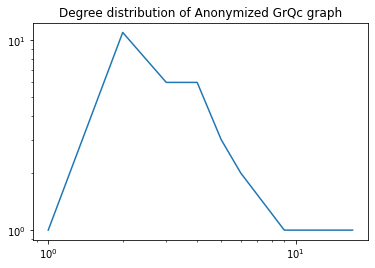

In [7]:
g=G1
degrees = {}
counts = []
for n in g.nodes():
    degree_n = g.degree(n)
    counts.append(degree_n)
    if degree_n not in degrees:
        degrees[degree_n] = 0
    degrees[degree_n] += 1

# Degree Distribution
items = sorted(degrees.items())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([k for (k,v) in items], [v for (k,v) in items])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Degree distribution of Anonymized GrQc graph")

In [16]:
e1=GraphAnon(edgeList=edgeList,K=3)

Executing Graph anonymization algorithm.
Average degree: 3
Bridges: 1
Cut Vertices: 1
Frequency: 0.5
Strong Edges: 4
Weak Edges: 74
Num edges added at step 4: 2
New Cut Vertices: [1]
New Bridges: []
Executing step 4.
Edges added at 4th step: 0
Executing step 7.
Edges added at 7th step: 1
Edges added at Addnl step: 3
Total edges added After step7: 6
Executing step 8.
U: [12, 13, 18, 22, 10, 17, 15, 16, 19, 21, 23, 27, 'd1->12']
L: 1
K: 3
Num of Edges Added: 13
Time taken: 0
L: 2
K: 3
Num of Edges Added: 160
Time taken: 0
L: 3
K: 3
Num of Edges Added: 120
Time taken: 17
Executing step 8.
edges added at step8: 6
No of Edges Added: 305
No of duplicate nodes: 5


In [194]:
nx.write_gexf(graph, "K_L.gexf")

Executing Graph anonymization algorithm.
Average degree: 10
Bridges: 0
Cut Vertices: 0
Frequency: 0.7352941176470589
Strong Edges: 0
Weak Edges: 293
Executing step 8.
U: []
L: 1
K: 5
Num of Edges Added: 0
Time taken: 0
L: 2
K: 5
Num of Edges Added: 0
Time taken: 0
Executing step 8.
None
No of Edges Added: 20
No of duplicate nodes: 10


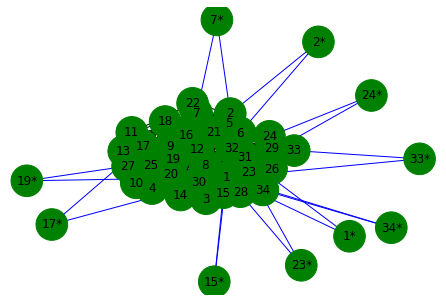

In [196]:
e2=GraphAnon(edgeList=e1,K=5)

In [156]:
# nx.write_gexf(graph, "K_L.gexf")

In [197]:
graph1 = nx.Graph()
graph1.add_edges_from(e1)

In [198]:
nx.info(graph1)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 293\nAverage degree:  17.2353'

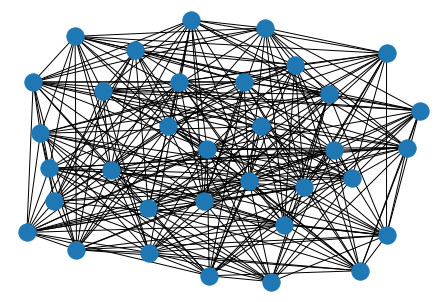

In [199]:
nx.draw(graph1)

In [124]:
# nx.write_gexf(graph, "K_L.gexf")

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: 0
Cut Vertices: 0
Frequency: 0.8529411764705882
Strong Edges: 0
Weak Edges: 385
Executing step 8.
U: []
L: 1
K: 10
Num of Edges Added: 0
Time taken: 0
L: 2
K: 10
Num of Edges Added: 0
Time taken: 0
Executing step 8.
None
No of Edges Added: 22
No of duplicate nodes: 10


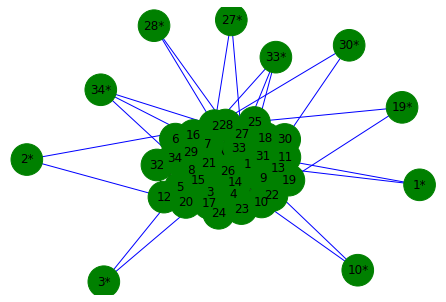

In [140]:
e2=GraphAnon(edgeList=e1,K=10)

In [141]:
# nx.write_gexf(graph, "K_L.gexf")

In [170]:
graph1 = nx.Graph()
graph1.add_edges_from(e2)

In [171]:
nx.info(graph1)

'Name: \nType: Graph\nNumber of nodes: 44\nNumber of edges: 313\nAverage degree:  14.2273'

In [173]:
nx.write_gexf(graph1, "Kar1.gexf")

Text(0.5, 1.0, 'Degree distribution of Anonymized GrQc graph')

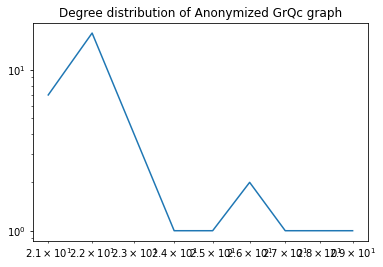

In [174]:
g=graph
degrees = {}
counts = []
for n in g.nodes():
    degree_n = g.degree(n)
    counts.append(degree_n)
    if degree_n not in degrees:
        degrees[degree_n] = 0
    degrees[degree_n] += 1

# Degree Distribution
items = sorted(degrees.items())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([k for (k,v) in items], [v for (k,v) in items])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Degree distribution of Anonymized GrQc graph")

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: []
Frequency: 0.7
Strong Edges: [(1, 4), (1, 6), (1, 7), (1, 8), (1, 17), (1, 26), (1, 23), (3, 8), (4, 8), (4, 23), (4, 17), (4, 5), (4, 7), (4, 21), (4, 11), (4, 24), (5, 7), (6, 7), (6, 'd1'), (7, 17), (7, 10), (7, 15), (7, 20), (8, 13), (8, 15), (8, 11), (9, 33), (9, 30), (9, 28), (9, 15), (9, 27), (11, 10), (11, 21), (12, 16), (13, 'd1'), (13, 14), (13, 32), (18, 22), (18, 10), (32, 'd1'), ('V->1', 33), (29, 33), (28, 10), (28, 16), (28, 19), (17, 23), (17, 24), (16, 10), (15, 10), (15, 23), (15, 30), (25, 33), (23, 24), (19, 34)]
Weak Edges: [(1, 2), (1, 3), (1, 5), (1, 9), (1, 11), (1, 12), (1, 13), (1, 14), (1, 18), (1, 20), (1, 22), (1, 32), (1, 'd1'), (1, 'V->1'), (1, 29), (1, 28), (1, 16), (1, 15), (1, 25), (1, 10), (1, 21), (1, 30), (1, 27), (1, 33), (1, 24), (1, '1*'), (1, '19*'), (1, '34*'), (2, 3), (2, 4), (2, 8), (2, 14), (2, 18), (2, 20), (2, 22), (2, 31), (2, 6), (2, 7), (2, 28), (2,

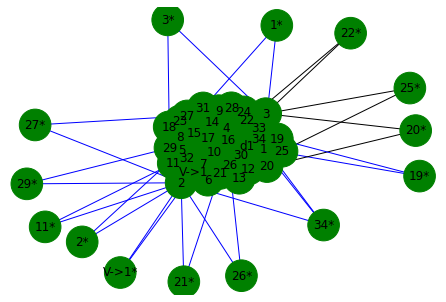

In [116]:
e3=GraphAnon(edgeList=e2,K=10)

In [49]:
graph2 = nx.Graph()
graph2.add_edges_from(e3)

In [50]:
nx.info(graph2)

'Name: \nType: Graph\nNumber of nodes: 41\nNumber of edges: 178\nAverage degree:   8.6829'

Executing Graph anonymization algorithm.
Average degree: 5
Bridges: []
Cut Vertices: []
Frequency: 0.7073170731707317
Strong Edges: [(6, 7)]
Weak Edges: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 13), (1, 14), (1, 18), (1, 20), (1, 22), (1, 32), (1, 'd1'), (1, 'V->1'), (1, 27), (1, 23), (1, 29), (1, 19), (1, 15), (1, '1*'), (1, '28*'), (1, '21*'), (1, '24*'), (1, '10*'), (1, 26), (2, 3), (2, 4), (2, 8), (2, 14), (2, 18), (2, 20), (2, 22), (2, 31), (2, 15), (2, 12), (2, 28), (2, 21), (2, 19), (2, 'V->1'), (2, 27), (2, 24), (3, 4), (3, 8), (3, 9), (3, 10), (3, 14), (3, 28), (3, 29), (3, 33), (3, 'd1'), (3, 12), (3, 18), (3, 13), (3, 27), (3, 22), (3, 16), (3, 21), (3, 23), (4, 8), (4, 13), (4, 14), (4, 20), (4, 19), (4, 16), (4, 29), (4, 23), (4, 18), (4, 24), (5, 7), (5, 11), (5, 31), (5, 'V->1'), (5, 6), (6, 11), (6, 17), (7, 17), (7, 11), (8, 'd1'), (8, 30), (9, 31), (9, 33), (9, 34), (11, 33), (11, 30), (12, 'd1'), (12, 30), (12, 33), (13, 

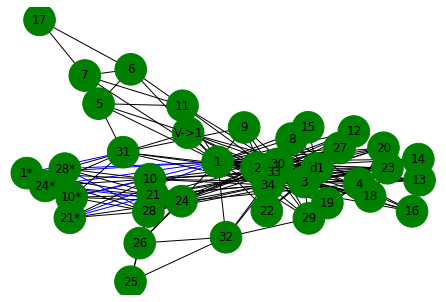

In [51]:
e4=GraphAnon(edgeList=e3,K=3)

Executing Graph anonymization algorithm.
Average degree: 5
Bridges: []
Cut Vertices: []
Frequency: 0.7073170731707317
Strong Edges: [(6, 7)]
Weak Edges: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 13), (1, 14), (1, 18), (1, 20), (1, 22), (1, 32), (1, 'd1'), (1, 'V->1'), (1, 27), (1, 23), (1, 29), (1, 19), (1, 15), (1, '1*'), (1, '28*'), (1, '21*'), (1, '24*'), (1, '10*'), (1, 26), (2, 3), (2, 4), (2, 8), (2, 14), (2, 18), (2, 20), (2, 22), (2, 31), (2, 15), (2, 12), (2, 28), (2, 21), (2, 19), (2, 'V->1'), (2, 27), (2, 24), (3, 4), (3, 8), (3, 9), (3, 10), (3, 14), (3, 28), (3, 29), (3, 33), (3, 'd1'), (3, 12), (3, 18), (3, 13), (3, 27), (3, 22), (3, 16), (3, 21), (3, 23), (4, 8), (4, 13), (4, 14), (4, 20), (4, 19), (4, 16), (4, 29), (4, 23), (4, 18), (4, 24), (5, 7), (5, 11), (5, 31), (5, 'V->1'), (5, 6), (6, 11), (6, 17), (7, 17), (7, 11), (8, 'd1'), (8, 30), (9, 31), (9, 33), (9, 34), (11, 33), (11, 30), (12, 'd1'), (12, 30), (12, 33), (13, 

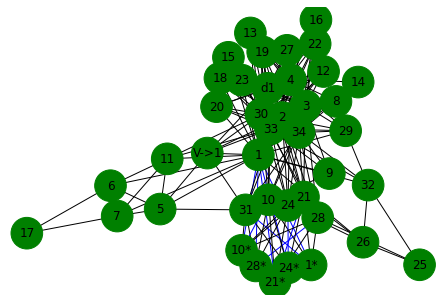

In [52]:
e5=GraphAnon(edgeList=e4,K=3)

In [60]:
nx.write_gexf(graph2, "Karate.gexf")

NameError: name 'logFile' is not defined

NameError: name 'K' is not defined

Executing Graph anonymization algorithm.
Average degree: 11
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 3
No of duplicate nodes: 0


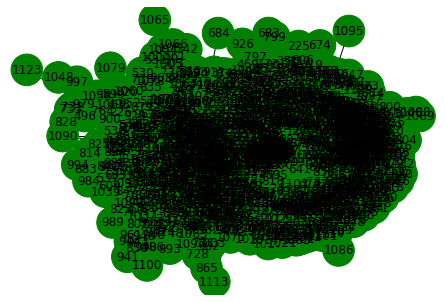

In [17]:
e6=GraphAnon(edgeList=e5)

Executing Graph anonymization algorithm.
Average degree: 11
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


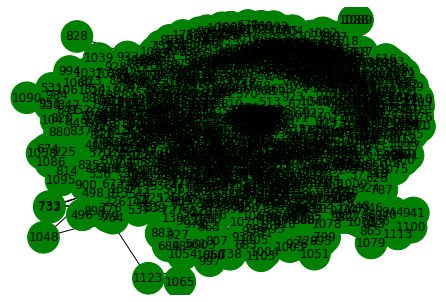

In [18]:
e7=GraphAnon(edgeList=e6)

Executing Graph anonymization algorithm.
Average degree: 11
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


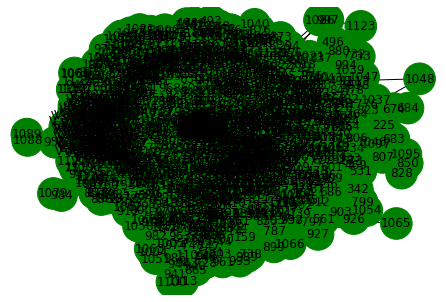

In [19]:
e8=GraphAnon(edgeList=e7)

Executing Graph anonymization algorithm.
Average degree: 11
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


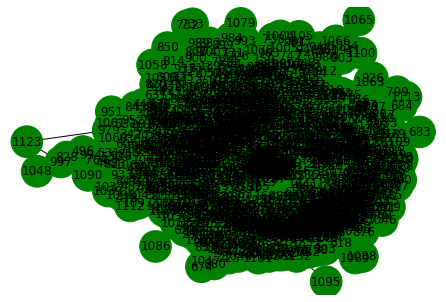

In [20]:
e9=GraphAnon(edgeList=e8)

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


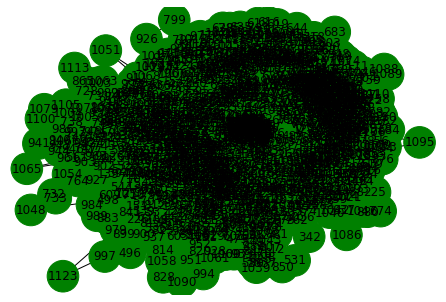

In [21]:
e10=GraphAnon(edgeList=e9)

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


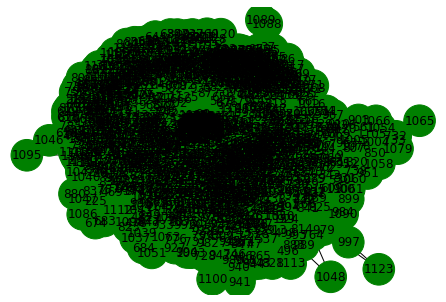

In [22]:
e11=GraphAnon(edgeList=e10)

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


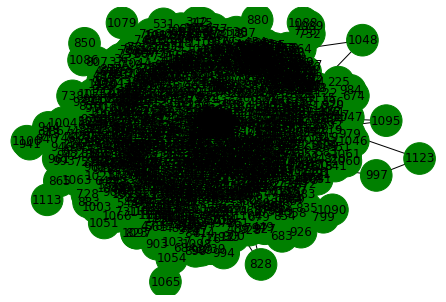

In [23]:
e12=GraphAnon(edgeList=e11)

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


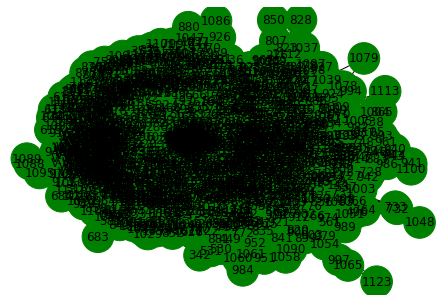

In [24]:
e13=GraphAnon(edgeList=e12)

Executing Graph anonymization algorithm.
Average degree: 12
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


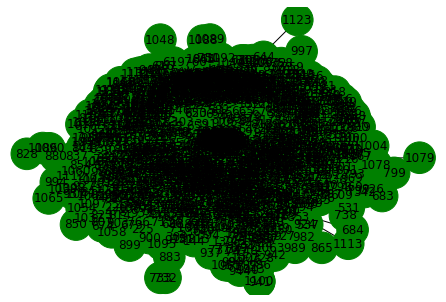

In [25]:
e14=GraphAnon(edgeList=e13)

In [26]:
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 1420\nNumber of edges: 14920\nAverage degree:  21.0141'

In [27]:
def number_of_fake_edges(G_orig, G_san):
    """
    Get the percent of fake edges added  
    :param G_orig: 
    :param G_san: 
    :return: 
    """
    E1 = set(G_orig.edges())
    E2 = set(G_san.edges())
    return 1. - float(len(E1 & E2)) / len(E2)

def distortion(G_orig, G_san):
    """
    Calculate distortion value - number of noise added
    :param G_orig: 
    :param G_san: 
    :return: 
    """
    E1 = set(G_orig.edges())
    E2 = set(G_san.edges())
    return float(len(E1 | E2 - E1 & E2)) / len(E1)

In [28]:
%%time
print("Originial edges ", G1.number_of_edges(), " Now edges ", graph.number_of_edges())

print("% of fake edges")
print(number_of_fake_edges(G1, graph))
#print(number_of_fake_edges(G2, G_san))

print("% of distortion")
print(distortion(G1, graph))
#print(distortion(G2, G_san))

Originial edges  5452  Now edges  14920
% of fake edges
0.6345844504021447
% of distortion
2.736610418195158
Wall time: 69 ms


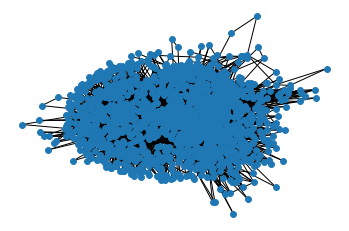

In [29]:
SPO=nx.spring_layout(graph)

plt.axis('off')
nx.draw_networkx(graph,pos=SPO, with_labels=False,node_size=35)

In [30]:
nx.shortest_path(G1,160,664)

[160, 13, 106, 664]

In [31]:
nx.shortest_path(graph,160,664)

[160, 664]

In [32]:
from itertools import islice
def k_shortest_paths(G1, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G1, source, target,weight=weight), k))
for path in k_shortest_paths(graph, 160,664,7):
    print(path)

[160, 664]
[160, 98, 664]
[160, 307, 664]
[160, 287, 664]
[160, 714, 664]
[160, 277, 664]
[160, 326, 664]


In [33]:
from itertools import islice
def k_shortest_paths(graph, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(graph, source, target,weight=weight), k))
for path in k_shortest_paths(graph, 160,664,7):
    print(path)

[160, 664]
[160, 98, 664]
[160, 307, 664]
[160, 287, 664]
[160, 714, 664]
[160, 277, 664]
[160, 326, 664]


In [27]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(jazzArenas, partition, sensitive_column) >= l